## Import our libraries

In [1]:
%matplotlib inline
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.

import pandas as pd # to manage data frames and reading csv files

## Set our Global Variables
later you will need to modify these to present your solution to the Exercise

In [2]:
#number of input, hidden and output nodes
input_nodes = 784 #we have 28 * 28 matrix to describe each digit
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.3
batch_size = 10

# epochs is the number of training iterations 
epochs = 30

# datasets to read
# you can change these when trying out other datasets
train_file = "data/mnist_train.csv"
test_file = "data/mnist_test.csv"

## Specify our Dataset for Classification
Note we have indicated a train set for model training and test set for testing the learned model

## MNIST dataset
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.
The database is also widely used for training and testing in the field of machine learning.
It was created by "re-mixing" the samples from NIST's original datasets. 
The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments.
Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.
<img src="mnist.png">
 
The MNIST database contains 60,000 training images and 10,000 testing images.
Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset.
There have been a number of scientific papers on attempts to achieve the lowest error rate; one paper, using a hierarchical system of convolutional neural networks, manages to get an error rate on the MNIST database of 0.23 percent.
The original creators of the database keep a list of some of the methods tested on it.
In their original paper, they use a support vector machine to get an error rate of 0.8 percent.

### MINIST for the lab
Our training and test set contains 60K and 10K instances.
To reduce the time taken for training we can use a smaller random sample during our lab. 

Lets use the pandas library to have a look at an instance in the MNIST dataset below.

You can change the idx value to access different instances (example below accesses the 21st indexed instance)


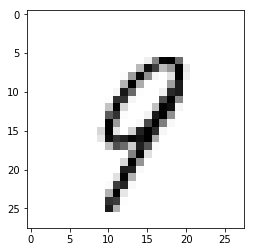

In [3]:
#read the file into a pandas frame
df = pd.read_csv(train_file) 

#get a specific instance and read values other than position 1 e.g. slice using 1:
idx = 21
instance = df.iloc[idx:(idx+1), 1:].values

# now reshape the 784 features into a 28x28 grid
# here asfarray helps to convert values into real numbers
image_array = np.asfarray(instance).flatten().reshape((28,28))

# print the grid in grey scale
plt.imshow(image_array, cmap='Greys', interpolation='None') 



In [4]:
#load the mnist training data CSV file into a list
train_data_file = open(train_file, 'r')
train_data_list = train_data_file.readlines() # read all lines into memory 
train_data_file.close() 
print("train set size: ", len(train_data_list))

#testing the network
#load the mnist test data CSV file into a list
#test_data_file = open("mnist/mnist_test_10.csv", 'r') # read the file with 10 instances first
test_data_file = open(test_file, 'r') # read the file with 10 instances first
test_data_list = test_data_file.readlines()
test_data_file.close()
print("test set size: ", len(test_data_list))

train set size:  60000
test set size:  10000


## Build our Artificial Neural Network class
Some of the key methods include:

- __init__ : initialisation method to set all the class variables
- train : this is the method that implments the forward and back ward pass as well as updating the wights. You should study the weight update lines to understand ; which values actually contribute to the modification of weights. Note there are two sets of weights - wih are wwights from input to hidden nodes; and who weights from hidden to output nodes.
- test: this takes a set in test instances and queries the network to obtain a prediction which can then be compared against the expected target class to compute accuracy

Some of the key hyper-parameters include:
- ep (epoch) which is the number of training iterations on the full dataset); 
- lr (learning rate) the amount of moderation used to manage by how much we adjust the weights
- batch_size the number of examples considered within a single epoch before updating network parameters; 
- hnodes (hidden nodes) the number of hidden layer nodes


In [5]:
class neuralNetwork:
    """Artificial Neural Network classifier.

    Parameters
    ------------
    lr : float
      Learning rate (between 0.0 and 1.0)
    ep : int
      Number of epochs for training the network towards achieving convergence
    batch_size : int
      Size of the training batch to be used when calculating the gradient descent. 
      batch_size = 0 standard gradient descent
      batch_size > 0 stochastic gradient descent 

    inodes : int
      Number of input nodes which is normally the number of features in an instance.
    hnodes : int
      Number of hidden nodes in the net.
    onodes : int
      Number of output nodes in the net.


    Attributes
    -----------
    wih : 2d-array
      Input2Hidden node weights after fitting 
    who : 2d-array
      Hidden2Output node weights after fitting 
    E : list
      Sum-of-squares error value in each epoch.
      
    Results : list
      Target and predicted class labels for the test data.
      
    Functions
    ---------
    activation_function : float (between 1 and -1)
        implments the sigmoid function which squashes the node input

    """

    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.3, batch_size=10, epochs=30):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        #link weight matrices, wih (input to hidden) and who (hidden to output)
        #a weight on link from node i to node j is w_ij
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
   
    def batch_input(self, input_list):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(input_list), self.bs):
            yield input_list[i:i + self.bs]
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
      
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for batch in self.batch_input(train_inputs):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for instance in batch:
                    # split it by the commas
                    all_values = instance.split(',')
                    # scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
                    # divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
                    # multiply by 0.99 to bring them into the range 0.0 - 0.99.
                    # add 0.01 to shift them up to the desired range 0.01 - 1. 
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    #create the target output values for each instance so that we can use it with the neural net
                    #note we need 10 nodes where each represents one of the digits
                    targets = np.zeros(output_nodes) + 0.01 #all initialised to 0.01
                    #all_value[0] has the target class label for this instance
                    targets[int(all_values[0])] = 0.99
        
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
            
                       
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we dont need to bother with an average
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        pass # epoch
    
    #query the neural net
    def query(self, inputs_list):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs):
        self.results = []
        
        #go through each test instances
        for instance in test_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
    
            target_label = int(all_values[0]) # get the target class for the instance
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query(inputs)
    
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
    
            self.results.append([predict_label, target_label])
            #compute network error
            #if (predict_label == target_label):
            #    self.results.append(1)
            #else: 
            #    self.results.append(0)
            pass
        pass
        self.results = np.asfarray(self.results) # flatten results to avoid nested arrays
    
        
    

In [6]:
# train_data_list

## Train the Artificial Neural Net

In [7]:
#create instance of neuralnet
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)

# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
n.train(mini_training_data)

Percentage of training data used: 2.5
Training epoch#:  0
errors (SSE):  [645.44224271]
Training epoch#:  1
errors (SSE):  [341.33521944]
Training epoch#:  2
errors (SSE):  [278.01855833]
Training epoch#:  3
errors (SSE):  [238.47906568]
Training epoch#:  4
errors (SSE):  [209.54355869]
Training epoch#:  5
errors (SSE):  [186.83001975]
Training epoch#:  6
errors (SSE):  [168.35535344]
Training epoch#:  7
errors (SSE):  [152.99740871]
Training epoch#:  8
errors (SSE):  [139.96250266]
Training epoch#:  9
errors (SSE):  [128.6676244]
Training epoch#:  10
errors (SSE):  [118.72807433]
Training epoch#:  11
errors (SSE):  [109.89132798]
Training epoch#:  12
errors (SSE):  [101.97864093]
Training epoch#:  13
errors (SSE):  [94.73630813]
Training epoch#:  14
errors (SSE):  [87.87594537]
Training epoch#:  15
errors (SSE):  [81.56950316]
Training epoch#:  16
errors (SSE):  [75.80788734]
Training epoch#:  17
errors (SSE):  [70.45972997]
Training epoch#:  18
errors (SSE):  [65.53222024]
Training e

In [8]:
# mini_training_data

## Plot the model error with increasing epochs

Error at the end of each epoch has been stored in self.E
We can now use mathplotlib to plot the error at the end of each epoch. 
Our expectation is that as we continue to descend (hill-walking) we should move closer to the minima
as such error should decrease. 

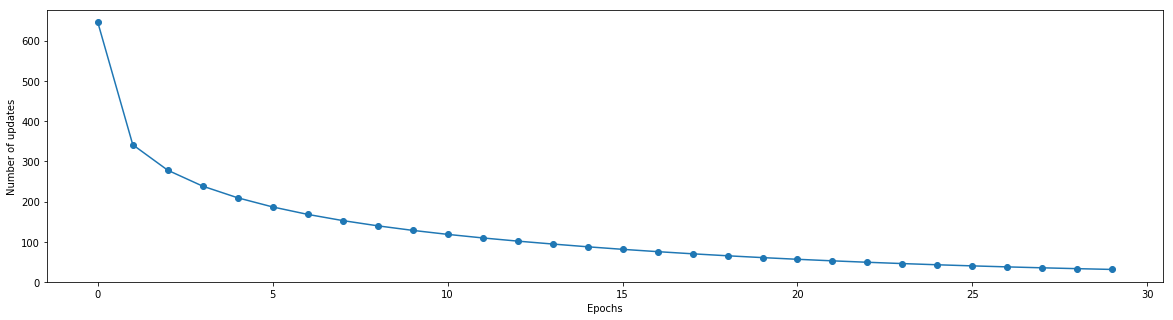

In [9]:
#print the error over epochs

plt.figure(figsize=(20,5)) #width, height settings for figures
plt.plot(range(0, n.ep), np.asfarray(n.E), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of errors')



# plt.savefig('images/02_07.png', dpi=300)
plt.show()

## Test the ANN and compute the Accuracy
We will keep track of the predicted and actual outputs in order to 
calculate the accuracy of the model on the unseen test data. 


In [10]:
n.test(test_data_list)
#print network performance as an accuracy metric
correct = 0 # number of predictions that were correct

#iteratre through each tested instance and accumilate number of correct predictions
for result in n.results:
    if (result[0] == result[1]):
            correct += 1
    pass
pass

# print the accuracy on test set
print ("Test set accuracy% = ", (100 * correct / len(n.results)))

Test set accuracy% =  91.53


## Exploring different values of a hyperparameter - a study on the batch_size
Often we need to explore a variety of values for an algorithms hyper parameters before we can suggest the best model. For instance with the ANN we can study the accuracy by changing the number of epochs, or the batch_size or learning rate , for instance. 

Lets look at what happens when the batch size 
- batch_size = size of training data; we adopt the Gradient Decent (GD) approach to optimisaing the ANN's weights. This means that the weights are updated once at each epoch (= pass over the training dataset). The amount by which we update is an aggregation over all the training instances. 

- batch_size = 1, we adopt the Stochastic Gradient Descent (SGD) optimisation approach to updating weights. SGD is sometimes also referred to as iterative or on-line Gradient Decent (GD). In a given epoch we update the weights many times. That is to say that we check the error with each training instance; compute the gradient and update the weights. As such we don't accumulate the weight updates as we do with GD.
Here, the term "stochastic" comes from the fact that the gradient based on a single training sample is a "stochastic approximation" of the "true" cost gradient. Due to its stochastic nature, the path towards the global cost minimum is not "direct" as in GD, but may go "zig-zag" if we are visualizing the cost surface in a 2D space. However, it has been shown that SGD although is time consuming is more likely to converge to the global cost minimum.

- batch_size >1 and < len(training data); this will be an inbetween mini-batch approach to updating the weights. 




In [11]:
# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

print("This will take a few moments ...")
n_list = []
batch_sizes = [1, 20, 100, 200, 500, len(mini_training_data)]

for batch_size in batch_sizes:
    n = neuralNetwork(batch_size=batch_size)
    n.train(mini_training_data)
    n_list.append(n)
    

Percentage of training data used: 2.5
This will take a few moments ...
Training epoch#:  0
errors (SSE):  [519.15404993]
Training epoch#:  1
errors (SSE):  [199.23028151]
Training epoch#:  2
errors (SSE):  [100.87757935]
Training epoch#:  3
errors (SSE):  [55.9240094]
Training epoch#:  4
errors (SSE):  [34.83650483]
Training epoch#:  5
errors (SSE):  [22.9323157]
Training epoch#:  6
errors (SSE):  [16.16920091]
Training epoch#:  7
errors (SSE):  [11.72489136]
Training epoch#:  8
errors (SSE):  [9.21712472]
Training epoch#:  9
errors (SSE):  [7.52368208]
Training epoch#:  10
errors (SSE):  [6.36532099]
Training epoch#:  11
errors (SSE):  [5.50773969]
Training epoch#:  12
errors (SSE):  [4.8261523]
Training epoch#:  13
errors (SSE):  [4.26533237]
Training epoch#:  14
errors (SSE):  [3.80875491]
Training epoch#:  15
errors (SSE):  [3.43938937]
Training epoch#:  16
errors (SSE):  [3.13915325]
Training epoch#:  17
errors (SSE):  [2.8921801]
Training epoch#:  18
errors (SSE):  [2.68094402]
T

errors (SSE):  [613.9204858]
Training epoch#:  13
errors (SSE):  [599.05052295]
Training epoch#:  14
errors (SSE):  [585.73134445]
Training epoch#:  15
errors (SSE):  [573.62132165]
Training epoch#:  16
errors (SSE):  [562.59137058]
Training epoch#:  17
errors (SSE):  [552.46346334]
Training epoch#:  18
errors (SSE):  [543.1289827]
Training epoch#:  19
errors (SSE):  [534.48171012]
Training epoch#:  20
errors (SSE):  [526.44040385]
Training epoch#:  21
errors (SSE):  [518.93410864]
Training epoch#:  22
errors (SSE):  [511.90383831]
Training epoch#:  23
errors (SSE):  [505.29901115]
Training epoch#:  24
errors (SSE):  [499.07634364]
Training epoch#:  25
errors (SSE):  [493.19845293]
Training epoch#:  26
errors (SSE):  [487.63288803]
Training epoch#:  27
errors (SSE):  [482.35132105]
Training epoch#:  28
errors (SSE):  [477.32889735]
Training epoch#:  29
errors (SSE):  [472.54370749]


# Gather the test results for each ANN

In [12]:
#iteratre through each model and accumilate number of correct predictions
model_results = []
for model in n_list: 
    correct = 0
    model.test(test_data_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass


# print the accuracy on test set
#print ("Test set accuracy% = ", (100 * correct / len(n.results)))

92.36999999999999
90.14
88.67
88.09
86.8
84.49


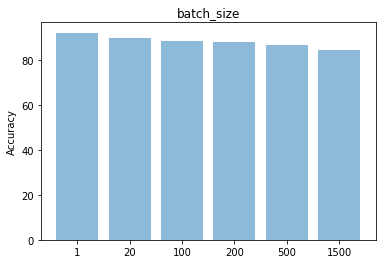

In [13]:
objects = batch_sizes
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('batch_size')
 
plt.show()

### Study the impact of varying two hyper parameters

In [14]:
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

print("This will take a few moments ...")
n_list = []
batch_sizes = [1, 20, 100, 200, 500, len(mini_training_data)]
hidden_nodes = [200, 5] # lets try two different configurations of hidden node layer

# lets create the set of modesl
for hidden in hidden_nodes:
    n_list_element = [] # first set of nets with a given hidden node size
    
    for batch in batch_sizes:
        n = neuralNetwork(batch_size=batch, hiddennodes=hidden)
        n.train(mini_training_data)
        n_list_element.append(n)
        pass
    
    n_list.append(n_list_element)# now append the set of models 
    pass

#lets test the models 
#iterate through each model and accumilate number of correct predictions
model_results = []
model_result_element = []

for model1 in n_list:
    model_result_element = []
    
    for model2 in model1:
        correct = 0
        model2.test(test_data_list)
        
        for result in model2.results:
           
            if (result[0] == result[1]): 
                correct +=1
            pass
        correct = 100 * (correct / len(model2.results))
        model_result_element.append(correct)
        print(correct)
        pass
    pass
    model_results.append(model_result_element)
    pass



Percentage of training data used: 2.5
This will take a few moments ...
Training epoch#:  0
errors (SSE):  [545.38168978]
Training epoch#:  1
errors (SSE):  [217.90180527]
Training epoch#:  2
errors (SSE):  [118.89944026]
Training epoch#:  3
errors (SSE):  [67.18894118]
Training epoch#:  4
errors (SSE):  [40.31980192]
Training epoch#:  5
errors (SSE):  [26.42949262]
Training epoch#:  6
errors (SSE):  [19.09211059]
Training epoch#:  7
errors (SSE):  [14.38558245]
Training epoch#:  8
errors (SSE):  [11.18149211]
Training epoch#:  9
errors (SSE):  [8.97266]
Training epoch#:  10
errors (SSE):  [7.42202659]
Training epoch#:  11
errors (SSE):  [6.29817862]
Training epoch#:  12
errors (SSE):  [5.4645259]
Training epoch#:  13
errors (SSE):  [4.8158098]
Training epoch#:  14
errors (SSE):  [4.29116567]
Training epoch#:  15
errors (SSE):  [3.85712827]
Training epoch#:  16
errors (SSE):  [3.49030555]
Training epoch#:  17
errors (SSE):  [3.17611029]
Training epoch#:  18
errors (SSE):  [2.90674386]
T

errors (SSE):  [666.55678026]
Training epoch#:  13
errors (SSE):  [648.89293687]
Training epoch#:  14
errors (SSE):  [633.02603238]
Training epoch#:  15
errors (SSE):  [618.69506286]
Training epoch#:  16
errors (SSE):  [605.6738196]
Training epoch#:  17
errors (SSE):  [593.78573121]
Training epoch#:  18
errors (SSE):  [582.88128423]
Training epoch#:  19
errors (SSE):  [572.83693169]
Training epoch#:  20
errors (SSE):  [563.54824128]
Training epoch#:  21
errors (SSE):  [554.92702892]
Training epoch#:  22
errors (SSE):  [546.89816339]
Training epoch#:  23
errors (SSE):  [539.39737077]
Training epoch#:  24
errors (SSE):  [532.36934664]
Training epoch#:  25
errors (SSE):  [525.76627781]
Training epoch#:  26
errors (SSE):  [519.54662748]
Training epoch#:  27
errors (SSE):  [513.6741497]
Training epoch#:  28
errors (SSE):  [508.1170794]
Training epoch#:  29
errors (SSE):  [502.84746541]
Training epoch#:  0
errors (SSE):  [1191.90409046]
Training epoch#:  1
errors (SSE):  [940.23634184]
Train

errors (SSE):  [1276.88252902]
Training epoch#:  24
errors (SSE):  [1273.39704673]
Training epoch#:  25
errors (SSE):  [1270.23793198]
Training epoch#:  26
errors (SSE):  [1267.35771256]
Training epoch#:  27
errors (SSE):  [1264.71642142]
Training epoch#:  28
errors (SSE):  [1262.28082073]
Training epoch#:  29
errors (SSE):  [1260.02331318]
Training epoch#:  0
errors (SSE):  [4156.13903282]
Training epoch#:  1
errors (SSE):  [3771.26760632]
Training epoch#:  2
errors (SSE):  [3652.75214462]
Training epoch#:  3
errors (SSE):  [3584.12848759]
Training epoch#:  4
errors (SSE):  [3519.64947176]
Training epoch#:  5
errors (SSE):  [3449.78845772]
Training epoch#:  6
errors (SSE):  [3374.02748569]
Training epoch#:  7
errors (SSE):  [3294.17659149]
Training epoch#:  8
errors (SSE):  [3211.66021235]
Training epoch#:  9
errors (SSE):  [3127.35901197]
Training epoch#:  10
errors (SSE):  [3042.20821672]
Training epoch#:  11
errors (SSE):  [2957.21697757]
Training epoch#:  12
errors (SSE):  [2873.0

## Plot the results of hidden nodes versus batch size

In the graph below we have plotted the accuracy for 6 different batch sizes comparing against 2 architectures (one with 200 hidden nodes and the other with 4 hidden nodes). 
As expected when the ANN architecture has fewer hidden nodes it has less oppertunity to learn a sensible mapping between the input features and expected outputs. 

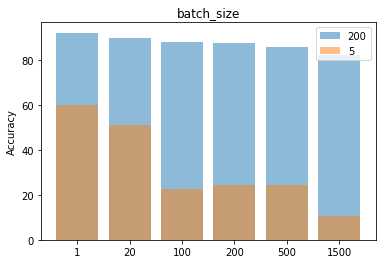

In [15]:
objects = batch_sizes

y_pos = np.arange(len(objects))
performance1 = model_results[0]
performance2 = model_results[1]
 
plt.bar(y_pos, performance1, align='center', alpha=0.5 )
plt.bar(y_pos, performance2, align='center', alpha=0.5)

plt.legend(hidden_nodes)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('batch_size')
 
plt.show()